In [1]:
import sys
sys.path.append('../')
import torch 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
import os
import torch.optim as optim
from utils.__init__ import *
from utils import custom_transforms
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys 
sys.path.append('../')
from model import load_model

2024-05-12 04:32:57.895733: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 04:32:57.897260: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 04:32:57.928426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 04:32:58.402568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([2, 1, 224, 224]) torch.Size([2, 1, 224, 224])
tensor(-1.) tensor(1.)
tensor([0., 1.])


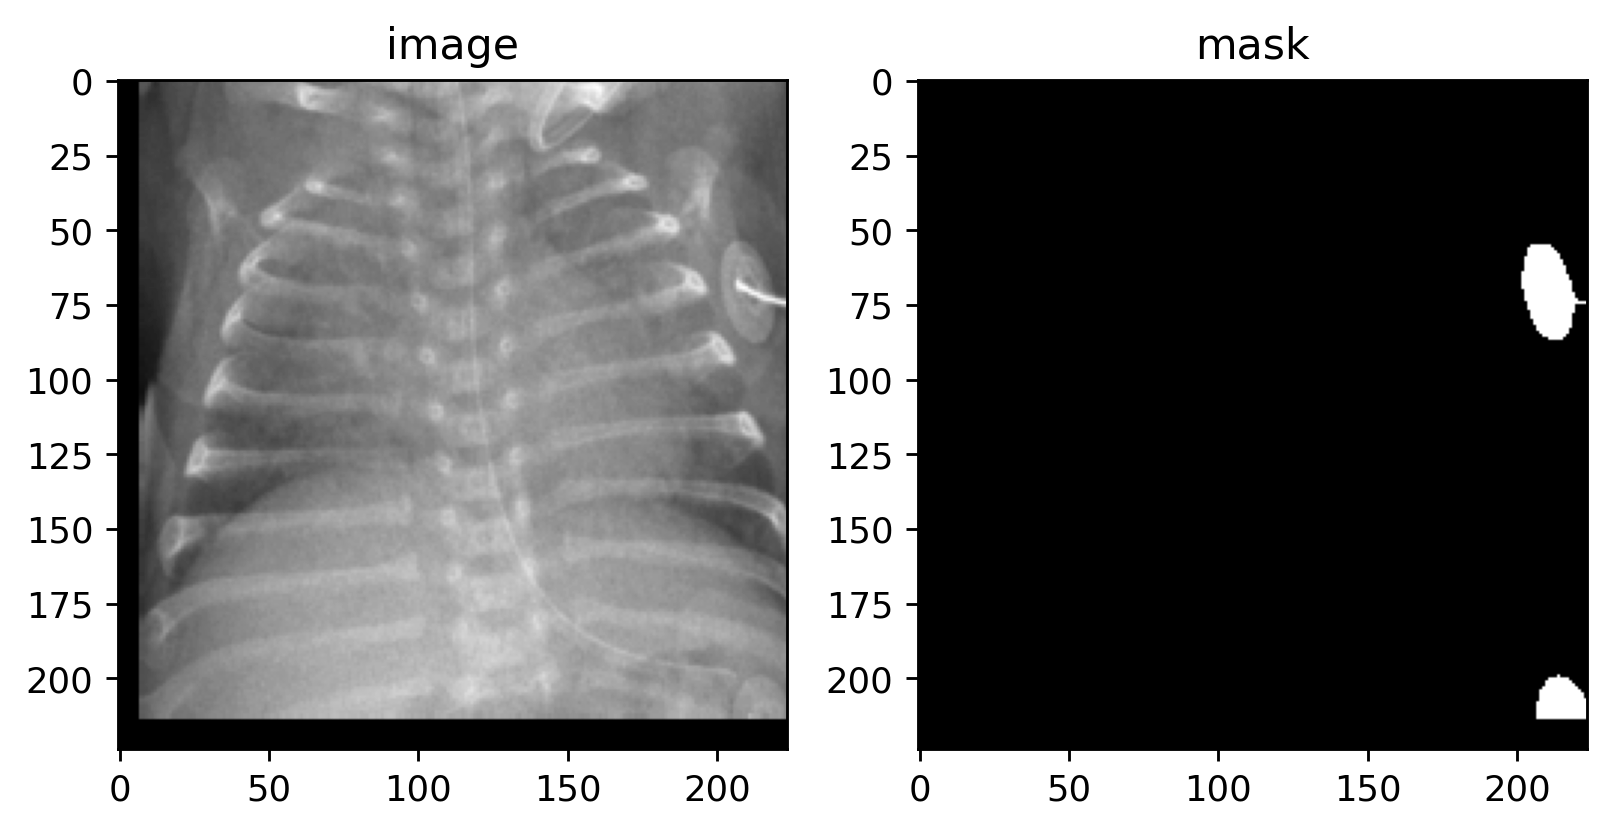

In [2]:
tr_img_dir = '/mnt/HDD/chest-seg/dataset/train_img'
tr_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
vl_img_dir = '/mnt/HDD/chest-seg/dataset/train_img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
    

transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomApply([custom_transforms.ApplyGaussianBlur(radius =2)], p=0.5),  # random apply 가우시안 노이즈 적용
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # 아핀 변환 적용
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # 선명도 조절
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) # [0, 1] -> [-1, 1] : 이게 실험적으로 더 좋은 신경망 학습
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Dataset and DataLoader setup
train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform=transform['train'],
    testing=False,
)

valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transform['valid'],
    testing=True,  # Disables random transformations for validation
    seed = 627
)
tr_batch, vl_batch = 2, 1
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    print(images.min(), images.max())
    print(masks.unique())
    
    train_plotting(images, masks)
    break

# for images, masks, paths in valid_loader:
#     print(images.shape, masks.shape)
#     train_plotting(images, masks)
#     break


In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

model_name = 'monai_swinunet'

save_path = os.path.join('/mnt/HDD/chest-seg_models', model_name)
os.makedirs(save_path, exist_ok=True)

model_loader = load_model.segmentation_models_loader(model_name = model_name)
model = model_loader().to(device)
            
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss().to(device)
metrics = {
    'train_loss':[], 'train_acc':[], 'train_iou':[], 
    'valid_loss':[], 'valid_acc':[], 'valid_iou':[],
}

print(f'output shape : {model(torch.randn(2, 1, 224, 224).to(device)).shape}')

Model: MONAI-SwinUNET loaded successfully!! | pretrained : None
output shape : torch.Size([2, 1, 224, 224])


In [4]:

from utils.metrics import calculate_metrics
for epoch in range(500):
    train_losses, train_accs, train_ious, valid_losses, valid_accs, valid_ious = 0, 0, 0, 0, 0, 0
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # BCE Logistic Loss
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_losses += loss.cpu().detach().item()
        acc, iou = calculate_metrics(outputs, masks)
        train_accs += acc
        train_ious += iou

    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### inference
            outputs = model(images)  # 3+1ch
            
            loss = loss_fn(outputs, masks)
            valid_losses += loss.cpu().detach().item()
            
            acc, iou = calculate_metrics(outputs, masks, 0.5)
            valid_accs += acc
            valid_ious += iou
            
    if epoch % 5 == 0:
        save_validation(images, masks, (outputs>0.5).int(), epoch, save_dir = save_path)
    #     save_model(model, optimizer, epoch, save_dir = save_path)
    #     save_loss(metrics, save_dir = save_path)

    metrics['train_loss'].append(train_losses / len(train_loader))
    metrics['train_acc'].append(train_accs / len(train_loader))
    metrics['train_iou'].append(train_ious / len(train_loader))
    metrics['valid_loss'].append(valid_losses / len(valid_loader))
    metrics['valid_acc'].append(valid_accs / len(valid_loader))
    metrics['valid_iou'].append(valid_ious / len(valid_loader))

    print("#" * 100)    
    print(f"Train - BCE : {metrics['train_loss'][-1]} | ACC : {metrics['train_acc'][-1]} | mIoU : {metrics['train_iou'][-1]} | ")
    print(f"Valid - BCE : {metrics['valid_loss'][-1]} | ACC : {metrics['valid_acc'][-1]} | mIoU : {metrics['valid_iou'][-1]} | ")
    print("#" * 100)
    


KeyboardInterrupt: 

In [ ]:
# model weight에서 dead weight 파라미터 개수 확인 
# 출력 : dead_weight / total_weight 
dead_weight, total_weight = 0, 0
for p in model.parameters():
    total_weight += p.numel()
    dead_weight += (p == 0).sum().item()
print(f"Dead Weight : {dead_weight} / {total_weight} = {dead_weight / total_weight * 100:.2f} %")

